In [ ]:
pip install pydicom pillow matplotlib tenseal torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
  

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving image-00014.dcm to image-00014.dcm


In [ ]:
import pydicom

dicom = pydicom.dcmread("image-00014.dcm")  # use your filename here
print(dicom)


Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 230
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.1055.1.20111102150759809.43319462.84114773
(0002,0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression
(0002,0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.1055.1
(0002,0013) Implementation Version Name         SH: 'dicomlibrary-100'
(0002,0016) Source Application Entity Title     AE: 'DICOMLIBRARY'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'HELIX']
(0008,0012) Instance Creation Date              DA: '20061012'
(0008,0013) Instance Creation Time              TM: '091609.000000'
(0008

/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: '1.2.826.0.1.3680043.8.1055.1.20111102150758591.96842950.07877442'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)


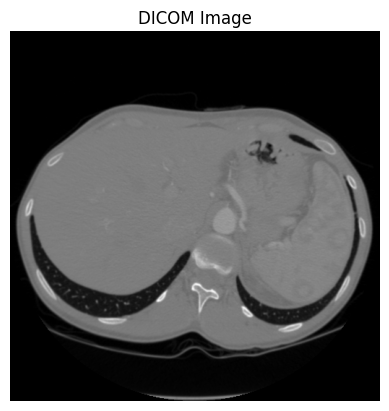

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(dicom.pixel_array, cmap='gray')
plt.title("DICOM Image")
plt.axis('off')
plt.show()

Saved PNG image to: /content/scan.png


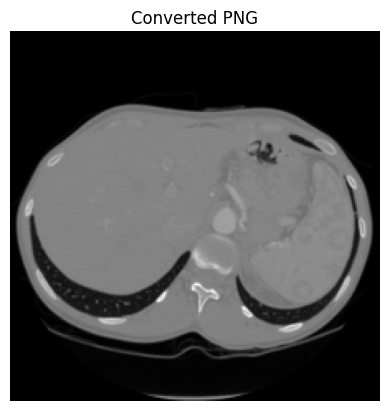

In [ ]:
import pydicom
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

def dicom_to_png(dicom_path, png_path="converted.png", size=(224, 224)):
    # Load the DICOM file
    dicom = pydicom.dcmread(dicom_path)

    # Extract pixel data
    pixels = dicom.pixel_array.astype(float)

    # Normalize to range 0–255
    pixels = (pixels - np.min(pixels)) / (np.max(pixels) - np.min(pixels))
    pixels = (pixels * 255).astype(np.uint8)

    # Create PIL image
    img = Image.fromarray(pixels)

    # Resize for ML model input
    img = img.resize(size)

    # Save as PNG
    img.save(png_path)

    print(f"Saved PNG image to: {os.path.abspath(png_path)}")

    # Display image
    plt.imshow(img, cmap="gray")
    plt.title("Converted PNG")
    plt.axis("off")
    plt.show()

# Example usage in Colab after upload
dicom_to_png("image-00014.dcm", "scan.png")


In [ ]:
def encrypt_image(png_path, context):
    img = Image.open(png_path).convert("L")
    img = img.resize((224, 224))  # Resize to 224x224 before encrypting
    pixels = np.array(img).astype(np.float32).reshape(-1)

    # Normalize
    pixels /= 255.0

    # Encrypt the image using TenSEAL
    enc_vector = ts.ckks_vector(context, pixels)
    return enc_vector


In [ ]:
def encrypt_weights(context, weights):
    enc_weights = []
    for i in range(weights.shape[0]):
        enc_weights.append(ts.ckks_vector(context, weights[i]))  # Encrypt each row of weights
    return enc_weights


# Step 4: Encrypted Inference (Dot Product + Bias)
def encrypted_inference(enc_vector, enc_weights, bias, context):
    encrypted_logits = []

    for i in range(len(enc_weights)):
        enc_weight = enc_weights[i]  # Encrypted weights for class i
        b = bias[i]  # Bias for class i

        # Perform dot product between encrypted input and encrypted weights
        dot = enc_vector.dot(enc_weight)

        # Encrypt the bias (so it's in the same encrypted space)
        enc_b = ts.ckks_vector(context, [b])  # Encrypt the bias, it's a scalar

        # Add the encrypted bias to the dot product
        dot += enc_b

        encrypted_logits.append(dot)

    return encrypted_logits

In [ ]:
def stable_softmax(logits):
    logits = logits - np.max(logits)  # Prevent overflow
    exp_scores = np.exp(logits)
    return exp_scores / np.sum(exp_scores)

def decrypt_and_predict(enc_logits_list, context):
    logits = np.array([enc.decrypt() for enc in enc_logits_list])
    probs = stable_softmax(logits)  # stable
    pred_class = np.argmax(probs)
    confidence = probs[pred_class]
    return pred_class, confidence, probs

In [ ]:
import numpy as np
import tenseal as ts

# Example of reshaping and then encrypting the data
data = np.random.rand(28, 28).flatten()  # Example: 28x28 image flattened into a vector of size 784

# Before encryption, reshape if necessary
reshaped_data = data.reshape(1, -1)  # Example reshape

# Set up the TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=16384,
    coeff_mod_bit_sizes=[40, 21, 21, 40]
)
context.generate_galois_keys()
context.global_scale = 2 ** 21

# Encrypt the data using TenSEAL's CKKSVector class
enc_vector = ts.ckks_vector(context, reshaped_data.flatten())

# Perform encrypted inference (using encrypted data, without reshaping)


Saved PNG image to: /content/converted_scan.png


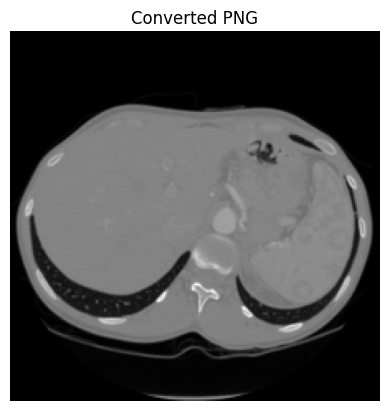


🔍 Predicted Class: 1, Confidence: 1.00
📊 Class Probabilities: 0.00, 1.00


In [ ]:
import tenseal as ts
import numpy as np

if __name__ == "__main__":
    # DICOM to PNG
    dicom_path = "image-00014.dcm"  # Replace with your DICOM file path
    png_path = "converted_scan.png"
    dicom_to_png(dicom_path, png_path)

    #TenSEAL context for encryption
    context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=16384,
    coeff_mod_bit_sizes=[40, 21, 21, 40]
    )
    context.generate_galois_keys()
    context.global_scale = 2 ** 21

    #Simulate model with random weights
    np.random.seed(0)
    weights = np.random.rand(2, 784).astype(np.float32)  # 2 output classes, 784 input features (for 28x28 image)
    bias = np.random.rand(2).astype(np.float32)  # Bias for each output class

    #Encrypt weights
    enc_weights = encrypt_weights(context, weights)

    #Perform encrypted inference
    enc_output = encrypted_inference(enc_vector, enc_weights, bias, context)

    #Decrypt and classify
    pred_class, confidence, probs = decrypt_and_predict(enc_output, context)

# Ensure confidence is a scalar
confidence_value = float(confidence[0]) if isinstance(confidence, (np.ndarray, list)) else float(confidence)

# Ensure each prob is a scalar float before formatting
formatted_probs = ', '.join([f"{prob.item():.2f}" for prob in probs])

print(f"\n🔍 Predicted Class: {pred_class}, Confidence: {confidence_value:.2f}")
print(f"📊 Class Probabilities: {formatted_probs}")


